In [137]:
import pandas as pd; import numpy as np; from multiprocessing import Pool, Manager; import numpy as np;
import fiona, shapely; from osgeo import ogr; from shapely.geometry import mapping, shape
import matplotlib.pyplot as plt; import seaborn as sns
import matplotlib, os, json, sys, time, datetime, pprint, pyproj
%matplotlib inline

# Difference in Home Location?

After we cluster again based on full contextual data, does the home location change?<br>
Does this mean a user is no longer _vulnerable_?

In [175]:
non_contextual_directory = '/data/chime/geo/zone_a_users_stage_2_temporal_clusters_with_home/'
contextual_directory     = '/data/chime/geo/zone_a_full_contexual/stage2/'

In [176]:
non_contextual_users_in = [x for x in sorted(os.listdir(non_contextual_directory)) if x != "temporal_clustered_user_meta.json"]
contextual_users_in     = [x for x in sorted(os.listdir(contextual_directory)) if x != "temporal_clustered_user_meta.json"]

print("Found {0} users in {1}".format(len(non_contextual_users_in), non_contextual_directory))
print("Found {0} users in {1}".format(len(contextual_users_in), contextual_directory))

Found 1258 users in /data/chime/geo/zone_a_users_stage_2_temporal_clusters_with_home/
Found 1188 users in /data/chime/geo/zone_a_full_contexual/stage2/


In [177]:
#Parallel Read Function
def loader_function(args):
    uFile, path, q = args
    u = json.load(open(path+"/"+uFile,'r'))
    tweets = []
    for t in u['features']:
        if t['geometry']:
            t['properties']['geometry'] = shape(t['geometry'])
#         t['properties']['date'] = pd.Timestamp(t['properties']['date'])
        tweets.append(t['properties'])
    
    df = pd.DataFrame(tweets)
    
#     df = df.sort_values(by='date')
    
    if not q is None:
        q.put(1)
    return df

In [178]:
#Parallel runtime
p = Pool(30); m = Manager(); q = m.Queue()

args = [(i, non_contextual_directory, q) for i in non_contextual_users_in]
result = p.map_async(loader_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed (non-contextual): {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))
non_contextual_users = result.get()
p.close()

#Parallel runtime
p = Pool(30); m = Manager(); q = m.Queue()

args = [(i, contextual_directory, q) for i in contextual_users_in]
result = p.map_async(loader_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed (contextual): {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))
contextual_users = result.get()
p.close()

Processed: 1188, 100%

In [179]:
def extract_home_location_coords(u):
    # u is a dataframe
    hc_id = u.home_cluster_id.values[0]
    cluster_center = u.query('cluster=='+str(hc_id)).cluster_center.values[0]
    user_name = u.user.values[0]
    return user_name, cluster_center

In [180]:
users = {}
for u in contextual_users:
    user_name, cluster_center = extract_home_location_coords(u)
    if user_name in users:
        users[user_name]['contextual_home_json'] = json.loads(cluster_center)
    else:
        users[user_name] = {'contextual_home_json' : json.loads(cluster_center)}
for u in non_contextual_users:
    user_name, cluster_center = extract_home_location_coords(u)
    if user_name in users:
        users[user_name]['non_contextual_home_json'] = json.loads(cluster_center)
    else:
        users[user_name] = {'non_contextual_home_json' : json.loads(cluster_center)}

In [195]:
distances = []
home_locs = 0
geod = pyproj.Geod(ellps='WGS84')

coll = {"type":"FeatureCollection","features":[]}

for name, homes in users.items():

    if 'non_contextual_home_json' in homes and 'contextual_home_json' in homes:
        home_locs += 1
        point1 = shape(homes['non_contextual_home_json'])
        point2 = shape(homes['contextual_home_json'])
        
        angle1,angle2,distance = geod.inv(point1.x, point1.y, point2.x, point2.y)
        
        if distance > 10: #meters
            
            distances.append({'user': name, 'd': distance})
            coll['features'].append({
                    "type":"Feature",
                    "properties":{"d":distance,"u":name},
                    "geometry":{
                        "type":"LineString", 
                        "coordinates":  [ homes['non_contextual_home_json']['coordinates'], 
                                          homes['contextual_home_json']['coordinates']]
                        }
                    })

print(len(distances))
print("Calculated for {0} users".format(home_locs))

43
Calculated for 1174 users


## Write out a visualization?

View here: http://www.townsendjennings.com/geojson-polygons?geojson=http://epic-analytics.cs.colorado.edu:9000/chime/movement-derivation/zone_a_home_location_change.geojson#1/37/-69

In [196]:
with open('/data/www/chime/movement-derivation/zone_a_home_location_change.geojson','w') as oFile:
    json.dump(coll,oFile)

In [197]:
for d in distances:
    print(d['user'],d['d'])

urihoresh 9113185.099147025
LUIS_CASTRO_NYC 8665534.492840387
ShahadTB 10617087.398178335
djerocny 23707.285074568474
RUSSIANMUELLER 819.3034295348732
pamelavenbass 6481241.933352296
juice2111 277352.72008968773
Fittedheadsnc96 2557792.9199518436
Mr_BuLLzEyE 24.29693147528204
choly1990 5277443.648944313
KJ_balakitsis 61678.519663999745
jeffpulver 9112490.353245825
HisMoon224 14590.306635265548
atornato 29.555178290158135
CarlosRibas 7402585.384063316
amandaa_suzanne 31996.837510656493
GildaOliveira82 6679.90346304234
PrincessDDS 24.729935493224524
CountSmacula 1166.9948531422472
Thomas_Wendt 16.1647759389921
M_TITTY 170322.38901201962
geezieff 107670.46865331096
cmckendry 5544729.646597251
Shaybod 648.9854728361552
lauragarza 12315022.19195785
Luvume1 21195.539792334577
JoaoCRRamos 6984882.247363133
THATS_ME_RYANN 267026.13109703164
mobay808 7994748.7822657535
7aflatna 9045081.447896782
e1weiss 56234.99659962626
HairWeLove 1756313.4537015574
_paciixbaybee 117556.79990601256
mr0drig 33.

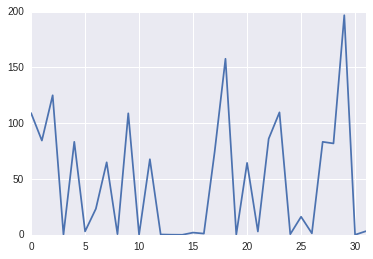

In [132]:
pd.Series(distances).plot()

In [121]:
user_names = list(users.keys())
for name in user_names[:10]:
    print(name)
    pprint.pprint(users[name])
    if 'contextual_home' in users[name]:
        print(users[name]['contextual_home'])

maryvdh
{'contextual_home_json': {'coordinates': [-73.9942999888889,
                                          40.680999151555554],
                          'type': 'Point'},
 'non_contextual_home_json': {'coordinates': [-73.9942999888889,
                                              40.680999151555554],
                              'type': 'Point'}}
angelazito12
{'contextual_home_json': {'coordinates': [-74.19705631770832, 40.5507577675],
                          'type': 'Point'}}
ElyKnuta
{'contextual_home_json': {'coordinates': [-73.95011597283784,
                                          40.81189825851352],
                          'type': 'Point'},
 'non_contextual_home_json': {'coordinates': [-73.95011366319444,
                                              40.81189851277779],
                              'type': 'Point'}}
caitysays
{'contextual_home_json': {'coordinates': [-73.9803315496447,
                                          40.74892321827408],
                   

In [90]:
len(user_names)

1272

In [105]:
contextual_users[0]

,cluster,cluster_center,coords,date,day_cluster,geo_delta,geometry,home_cluster_id,speed,text,time_delta,tweet_id,uid,user
0,NaN,null,None,2012-09-01 04:13:15+00:00,6,NaN,NaN,2.0,NaN,“@huny: michael jackson dance pordy (@ Le Pois...,-7861391.0,241750544262242304,17418108,11Zette17
1,NaN,null,None,2012-09-01 04:14:03+00:00,6,NaN,NaN,NaN,NaN,Butterflies.,48.0,241750745878241280,17418108,11Zette17
2,NaN,null,None,2012-09-01 04:20:48+00:00,6,NaN,NaN,NaN,NaN,#spotted @and_wayne!,405.0,241752442436452353,17418108,11Zette17
3,NaN,null,None,2012-09-01 04:40:23+00:00,6,NaN,NaN,NaN,NaN,Spotted the big sis @dj_diva + cousin @Carnegro,1175.0,241757371699978240,17418108,11Zette17
4,NaN,null,None,2012-09-01 04:45:50+00:00,6,NaN,NaN,NaN,NaN,Enjoy Yourself.,327.0,241758742423674880,17418108,11Zette17
5,NaN,null,None,2012-09-01 04:53:45+00:00,6,NaN,NaN,NaN,NaN,Finally spotted my @huny!,475.0,241760734059573248,17418108,11Zette17
6,NaN,null,None,2012-09-01 05:08:03+00:00,7,NaN,NaN,NaN,NaN,Baby Be Mine. #favoriteMJJsong,858.0,241764334584356864,17418108,11Zette17
7,1.0,"{""type"": ""Point"", ""coordinates"": [-74.00054383...","[-74.00054383, 40.72988293]",2012-09-01 05:22:29+00:00,7,NaN,POINT (-74.00054383 40.72988293),NaN,NaN,The fact they are playing Cash Money's Greates...,NaN,241767964918034432,17418108,11Zette17
8,NaN,null,None,2012-09-01 06:34:42+00:00,7,NaN,NaN,NaN,NaN,I could dance to Michael Jackson all night...h...,5199.0,241786141005725696,17418108,11Zette17
9,-1.0,null,"[-73.9999298, 40.72852827]",2012-09-01 06:35:30+00:00,7,159.269799,POINT (-73.9999298 40.72852827),NaN,0.036355,Unified for Heal the World @ Le Poisson Rouge...,4381.0,241786342252634112,17418108,11Zette17
